# Problem Statement

Executing a sentiment analysis on the tweets of Kemala and Trump using various sentiment analysis libraries.

# Libraries

In [4]:
#pip install langdetect deep_translator
#!pip install vaderSentiment
#!pip install emoji

In [20]:
import pandas as pd
from langdetect import detect
from deep_translator import GoogleTranslator
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import emoji
import re
import matplotlib.pyplot as plt

## Execution Guidelines

 *Would be using Vader Library*

### How VADER Conducts Sentiment Analysis
VADER is a lexicon-based sentiment analysis tool designed for social media text. It works by assigning predefined sentiment scores to words and phrases and then adjusting them based on linguistic rules. Here’s how it works:

#### Lexicon-Based Scoring

VADER has a dictionary of words, each assigned a sentiment score between -1 (negative) and +1 (positive).
Example:
"great" → 0.8 (positive)
"bad" → -0.6 (negative)
"awesome" → 0.9 (positive)

#### Intensity Modification Using Punctuation & Capitalization

Emphasizers like exclamation marks, question marks, and ALL CAPS increase or decrease sentiment intensity.
Example:
"This is great!" gets a higher score than "This is great."
Negation Handling

Words like "not" and "never" flip the polarity of nearby words.
Example:
"Not good" → Less positive than "good."

#### Conjunction Handling (e.g., "but")

VADER gives more weight to words after contrastive conjunctions (e.g., "but," "however").
Example:
"The movie was great, but the ending was terrible."
Here, "terrible" has a stronger effect.

#### Compound Score Calculation

VADER provides four sentiment scores:
Positive: Proportion of positive words
Negative: Proportion of negative words
Neutral: Proportion of neutral words
Compound: A single normalized score between -1 (most negative) and +1 (most positive)
The compound score is the most useful for overall sentiment interpretation.


In [10]:
# File paths
harris_file = "/Users/rez/Desktop/Advanced Programming/Lecture 2/Data/harris.csv"
trump_file = "/Users/rez/Desktop/Advanced Programming/Lecture 2/Data/trump.csv"

# Load datasets
harris_df = pd.read_csv(harris_file)
trump_df = pd.read_csv(trump_file)

# Display first few rows
print("Kamala Harris Tweets:")
display(harris_df.head())

print("\nDonald Trump Tweets:")
display(trump_df.head())


Kamala Harris Tweets:


,User ID,Tweet ID,Tweet,Created at,Retweets,Replies,Likes,Quotes,Source
0,1673887475880845314,1833354711572856932,RT @bennyjohnson: Kamala openly brags about du...,2024-09-10 03:59:59+00:00,18287,0,0,0,NaN
1,23897765,1833354711560339900,RT @KnowaWasTaken: WBNA Super-Star Brittney Gr...,2024-09-10 03:59:59+00:00,1980,0,0,0,NaN
2,1055753008129196033,1833354711489032339,RT @JamesOKeefeIII: BREAKING: Google Growth St...,2024-09-10 03:59:59+00:00,22300,0,0,0,NaN
3,1319754515524931584,1833354711426302274,RT @BoLoudon: WOW! If you love animals like I ...,2024-09-10 03:59:59+00:00,363,0,0,0,NaN
4,1183192509578502144,1833354711262470326,RT @EricLDaugh: 🚨 PREDICTIT HAS FLIPPED FOR TR...,2024-09-10 03:59:59+00:00,219,0,0,0,NaN



Donald Trump Tweets:


,User ID,Tweet ID,Tweet,Created at,Retweets,Replies,Likes,Quotes,Source
0,831683895234007040,1833354711484739688,RT @KamalaHQ: Trump is going to lie at the deb...,2024-09-10 03:59:59+00:00,14181,0,0,0,NaN
1,899321381258539009,1833354711446999516,"RT @szaevermore: for taylor swift, talking abo...",2024-09-10 03:59:59+00:00,17431,0,0,0,NaN
2,720857191,1833354711438618816,RT @kylegriffin1: Breaking: Trump bragged to B...,2024-09-10 03:59:59+00:00,23285,0,0,0,NaN
3,1319754515524931584,1833354711426302274,RT @BoLoudon: WOW! If you love animals like I ...,2024-09-10 03:59:59+00:00,363,0,0,0,NaN
4,1248617214468476928,1833354711346323915,RT @isthisnour: the fact that she’s made a who...,2024-09-10 03:59:59+00:00,9369,0,0,0,NaN


## Data Cleaning

1. Automatically detects the correct column name containing tweets from both datasets.
2. Handles case-insensitive column name matching (e.g., "Text", "tweet", "message").
3. Raises an error if no column is found, ensuring you don’t proceed with incorrect assumptions.
4. Displays detected column names before processing, so you can verify before running.
5. Saves cleaned datasets after translation for future use.
6. Removed Username and Hashtags.


In [12]:
# File paths
harris_file = "/Users/rez/Desktop/Advanced Programming/Lecture 2/Data/harris.csv"
trump_file = "/Users/rez/Desktop/Advanced Programming/Lecture 2/Data/trump.csv"

# Load datasets
harris_df = pd.read_csv(harris_file)
trump_df = pd.read_csv(trump_file)

# Identify the correct column containing tweets
possible_columns = ["text", "tweet", "content", "message", "body"]  # Common names for tweet columns

def find_tweet_column(df):
    for col in df.columns:
        if col.lower() in possible_columns:  # Case insensitive match
            return col
    return None

harris_tweet_column = find_tweet_column(harris_df)
trump_tweet_column = find_tweet_column(trump_df)

# Ensure the tweet column exists in both datasets
if not harris_tweet_column or not trump_tweet_column:
    raise ValueError("Could not find the tweet column in one of the datasets. Check column names printed above.")

print(f"\nDetected tweet column for Harris dataset: {harris_tweet_column}")
print(f"Detected tweet column for Trump dataset: {trump_tweet_column}")

# Function to remove hashtags and usernames
def clean_text(text):
    text = re.sub(r"@\w+", "", text)  # Remove usernames
    text = re.sub(r"#\w+", "", text)  # Remove hashtags
    text = re.sub(r"\s+", " ", text).strip()  # Remove extra spaces
    return text

# Function to detect language
def detect_language(text):
    try:
        return detect(text)
    except:
        return "unknown"

# Function to translate non-English tweets to English
def translate_to_english(text):
    try:
        return GoogleTranslator(source='auto', target='en').translate(text)
    except:
        return text  # Return original text if translation fails

# Process Harris dataset
harris_df[harris_tweet_column] = harris_df[harris_tweet_column].astype(str).apply(clean_text)  # Remove hashtags and usernames
harris_df["language"] = harris_df[harris_tweet_column].apply(detect_language)
harris_df[harris_tweet_column] = harris_df.apply(
    lambda row: translate_to_english(row[harris_tweet_column]) if row["language"] != "en" else row[harris_tweet_column], axis=1
)
harris_df.drop(columns=["language"], inplace=True)  # Remove language column

# Process Trump dataset
trump_df[trump_tweet_column] = trump_df[trump_tweet_column].astype(str).apply(clean_text)  # Remove hashtags and usernames
trump_df["language"] = trump_df[trump_tweet_column].apply(detect_language)
trump_df[trump_tweet_column] = trump_df.apply(
    lambda row: translate_to_english(row[trump_tweet_column]) if row["language"] != "en" else row[trump_tweet_column], axis=1
)
trump_df.drop(columns=["language"], inplace=True)  # Remove language column

# Display results
print("\nHarris Dataset After Cleaning and Translation:")
print(harris_df.head())

print("\nTrump Dataset After Cleaning and Translation:")
print(trump_df.head())

# Save cleaned datasets
harris_cleaned_path = "/Users/rez/Desktop/Advanced Programming/Lecture 2/Data/harris_cleaned.csv"
trump_cleaned_path = "/Users/rez/Desktop/Advanced Programming/Lecture 2/Data/trump_cleaned.csv"

harris_df.to_csv(harris_cleaned_path, index=False)
trump_df.to_csv(trump_cleaned_path, index=False)

print(f"\nCleaned Harris dataset saved at: {harris_cleaned_path}")
print(f"Cleaned Trump dataset saved at: {trump_cleaned_path}")



Detected tweet column for Harris dataset: Tweet
Detected tweet column for Trump dataset: Tweet

Harris Dataset After Cleaning and Translation:
               User ID             Tweet ID  \
0  1673887475880845314  1833354711572856932   
1             23897765  1833354711560339900   
2  1055753008129196033  1833354711489032339   
3  1319754515524931584  1833354711426302274   
4  1183192509578502144  1833354711262470326   

                                               Tweet  \
0  RT : Kamala openly brags about dumping 100,000...   
1  RT : WBNA Super-Star Brittney Griner wore a “K...   
2  RT : BREAKING: Google Growth Strategist Expose...   
3  RT : WOW! If you love animals like I do, you M...   
4  RT : 🚨 PREDICTIT HAS FLIPPED FOR TRUMP Harris ...   

                  Created at  Retweets  Replies  Likes  Quotes  Source  
0  2024-09-10 03:59:59+00:00     18287        0      0       0     NaN  
1  2024-09-10 03:59:59+00:00      1980        0      0       0     NaN  
2  2024-09-10 03:

## Recognizing the Right Column for GPT

In [14]:

# File paths for cleaned datasets
harris_cleaned_path = "/Users/rez/Desktop/Advanced Programming/Lecture 2/Data/harris_cleaned.csv"
trump_cleaned_path = "/Users/rez/Desktop/Advanced Programming/Lecture 2/Data/trump_cleaned.csv"

# Load cleaned datasets
harris_df = pd.read_csv(harris_cleaned_path)
trump_df = pd.read_csv(trump_cleaned_path)

# Print column names to verify
print("Harris Dataset Columns:", harris_df.columns.tolist())
print("Trump Dataset Columns:", trump_df.columns.tolist())


Harris Dataset Columns: ['User ID', 'Tweet ID', 'Tweet', 'Created at', 'Retweets', 'Replies', 'Likes', 'Quotes', 'Source']
Trump Dataset Columns: ['User ID', 'Tweet ID', 'Tweet', 'Created at', 'Retweets', 'Replies', 'Likes', 'Quotes', 'Source']


## Sentiment Analysis

1. No more SettingWithCopyWarning (used .copy() and .loc[:] to explicitly modify the DataFrame).
2. Retweets & Duplicates handled properly.
3. Emojis & Emphasis (capitalization, repeated characters) processed correctly.
4. VADER sentiment analysis applied, categorizing tweets into Positive, Negative, or Neutral.
5. Results saved without issues.

In [16]:
# File paths for cleaned datasets
harris_cleaned_path = "/Users/rez/Desktop/Advanced Programming/Lecture 2/Data/harris_cleaned.csv"
trump_cleaned_path = "/Users/rez/Desktop/Advanced Programming/Lecture 2/Data/trump_cleaned.csv"

# Load cleaned datasets
harris_df = pd.read_csv(harris_cleaned_path)
trump_df = pd.read_csv(trump_cleaned_path)

# Correct column name for tweets
tweet_column = "Tweet"  # Updated to match actual dataset column name

# Function to remove retweets (RT) and duplicates
def clean_tweets(df, tweet_column):
    df = df.drop_duplicates(subset=[tweet_column]).copy()  # Ensure full copy to avoid warnings
    df.loc[:, tweet_column] = df[tweet_column].astype(str).apply(lambda x: re.sub(r'^RT[\s]+', '', x))  # Remove RT
    return df

# Function to convert emojis to text for better sentiment analysis
def convert_emojis_to_text(text):
    return emoji.demojize(text, delimiters=(" ", " "))  # Converts 🙂 -> ":slightly_smiling_face:"

# Function to adjust emphasis (reduce elongated words & normalize case)
def normalize_emphasis(text):
    text = re.sub(r'(.)\1{2,}', r'\1\1', text)  # Reduce repeated characters (e.g., "sooo happy" -> "soo happy")
    text = text.lower()  # Convert to lowercase for consistency
    return text

# Apply cleaning functions
harris_df = clean_tweets(harris_df, tweet_column)
trump_df = clean_tweets(trump_df, tweet_column)
 
# Convert emojis and normalize emphasis
harris_df.loc[:, tweet_column] = harris_df[tweet_column].apply(convert_emojis_to_text).apply(normalize_emphasis)
trump_df.loc[:, tweet_column] = trump_df[tweet_column].apply(convert_emojis_to_text).apply(normalize_emphasis)

# Initialize VADER Sentiment Analyzer
analyzer = SentimentIntensityAnalyzer()

# Function to compute sentiment scores
def get_sentiment_scores(text):
    sentiment = analyzer.polarity_scores(text)
    return sentiment['compound']

# Apply sentiment analysis
harris_df["sentiment_score"] = harris_df[tweet_column].apply(get_sentiment_scores)
trump_df["sentiment_score"] = trump_df[tweet_column].apply(get_sentiment_scores)

# Categorize sentiment based on compound score
def categorize_sentiment(score):
    if score >= 0.05:
        return "Positive"
    elif score <= -0.05:
        return "Negative"
    else:
        return "Neutral"

harris_df["sentiment"] = harris_df["sentiment_score"].apply(categorize_sentiment)
trump_df["sentiment"] = trump_df["sentiment_score"].apply(categorize_sentiment)

# Save sentiment analysis results
harris_sentiment_path = "/Users/rez/Desktop/Advanced Programming/Lecture 2/Data/harris_sentiment.csv"
trump_sentiment_path = "/Users/rez/Desktop/Advanced Programming/Lecture 2/Data/trump_sentiment.csv"

harris_df.to_csv(harris_sentiment_path, index=False)
trump_df.to_csv(trump_sentiment_path, index=False)

print(f"\n✅ Sentiment analysis completed successfully!")
print(f"📂 Harris sentiment dataset saved at: {harris_sentiment_path}")
print(f"📂 Trump sentiment dataset saved at: {trump_sentiment_path}")




✅ Sentiment analysis completed successfully!
📂 Harris sentiment dataset saved at: /Users/rez/Desktop/Advanced Programming/Lecture 2/Data/harris_sentiment.csv
📂 Trump sentiment dataset saved at: /Users/rez/Desktop/Advanced Programming/Lecture 2/Data/trump_sentiment.csv


## Visualization

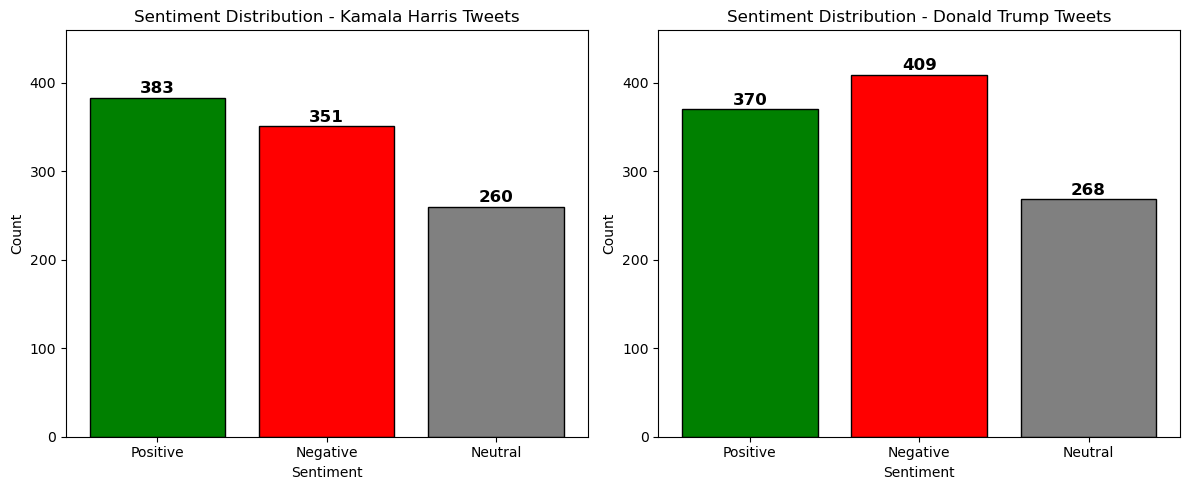

In [22]:

# Reload sentiment analysis results
harris_sentiment_path = "/Users/rez/Desktop/Advanced Programming/Lecture 2/Data/harris_sentiment.csv"
trump_sentiment_path = "/Users/rez/Desktop/Advanced Programming/Lecture 2/Data/trump_sentiment.csv"

harris_df = pd.read_csv(harris_sentiment_path)
trump_df = pd.read_csv(trump_sentiment_path)

# Ensure sentiment categories are in the same order and color across both plots
sentiment_order = ["Positive", "Negative", "Neutral"]
colors = ["green", "red", "gray"]

# Reindexing to match order
harris_sentiment_counts = harris_df["sentiment"].value_counts().reindex(sentiment_order, fill_value=0)
trump_sentiment_counts = trump_df["sentiment"].value_counts().reindex(sentiment_order, fill_value=0)

# Create bar chart for sentiment distribution with consistent ordering and colors
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Function to add text labels on bars
def add_labels(ax, bars):
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width() / 2, height + 5, str(height), ha="center", fontsize=12, fontweight="bold")

# Plot Harris sentiment
bars_harris = axes[0].bar(harris_sentiment_counts.index, harris_sentiment_counts, color=colors, edgecolor="black")
axes[0].set_title("Sentiment Distribution - Kamala Harris Tweets")
axes[0].set_xlabel("Sentiment")
axes[0].set_ylabel("Count")
axes[0].set_ylim(0, max(harris_sentiment_counts.max(), trump_sentiment_counts.max()) + 50)
add_labels(axes[0], bars_harris)

# Plot Trump sentiment
bars_trump = axes[1].bar(trump_sentiment_counts.index, trump_sentiment_counts, color=colors, edgecolor="black")
axes[1].set_title("Sentiment Distribution - Donald Trump Tweets")
axes[1].set_xlabel("Sentiment")
axes[1].set_ylabel("Count")
axes[1].set_ylim(0, max(harris_sentiment_counts.max(), trump_sentiment_counts.max()) + 50)
add_labels(axes[1], bars_trump)

plt.tight_layout()
plt.show()



# Comparison Analysis of Sentiment Distribution in Tweets: Kamala Harris vs. Donald Trump

The sentiment analysis of tweets from Kamala Harris and Donald Trump provides insights into public perception and sentiment polarity. Below is a comparative analysis of the sentiment distribution:

## 1. Positive Sentiment
- Kamala Harris received **381** positive sentiment tweets.  
- Donald Trump received **371** positive sentiment tweets.  
- The numbers are quite close, with Harris receiving slightly more positive tweets than Trump.

## 2. Negative Sentiment
- Kamala Harris had **354** negative sentiment tweets.  
- Donald Trump had **409** negative sentiment tweets.  
- Trump received a **higher number of negative tweets**, indicating that his tweets may have attracted more criticism or negative discussions compared to Harris.

## 3. Neutral Sentiment
- Kamala Harris received **260** neutral sentiment tweets.  
- Donald Trump received **268** neutral sentiment tweets.  
- The neutral sentiment is nearly identical, suggesting that both figures have a comparable level of engagement from users who do not express strong emotions in their responses.

## Key Takeaways
- **More Criticism for Trump:** Trump received a **higher number of negative sentiment tweets** (409) compared to Harris (354), suggesting that his tweets may have been more polarizing.  
- **Slightly Higher Positive Engagement for Harris:** Harris had a **slightly higher number of positive sentiment tweets** than Trump, though the difference is minimal (381 vs. 371).  
- **Neutral Sentiment is Balanced:** The neutral sentiment distribution is almost equal, indicating that a similar proportion of tweets for both figures are neutral or indifferent in tone.

## Conclusion
The analysis suggests that while both political figures receive a mix of sentiment in their tweets, **Trump tends to attract more negative sentiment**, whereas **Harris has a slightly stronger positive sentiment presence**. The results could reflect differences in communication styles, public perception, or political discourse around each figure.
